In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from typing import Tuple
from sklearn import preprocessing

In [43]:
def load_data() -> Tuple[np.ndarray, np.ndarray]:
    data = pd.read_csv("./data/data.csv").drop(["Unnamed: 0"], axis=1)
    labels = pd.read_csv("./data/labels.csv")["Class"]
        
    # Encodes string labels as ints
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(labels)
    
    return data.to_numpy(), y
X, y = load_data()

# First feature reduction to reduce run time

In [81]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Dropping the constant features
X_nonconst = VarianceThreshold().fit_transform(X)

# Doing feature selection by choosing the k features with the largest F-statistic
k = 200
X_fstat = SelectKBest(score_func=f_classif, k=k).fit_transform(X_nonconst, y)

# Feature selection using multi-class logistic regression

In [200]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

def cross_validate(n_folds, C_list, X, y):
    """
    Cross-validates the parameter values in C_list and
    returns a numpy.ndarray where the first index corresponds to the
    different values in C_list and the columns correspond
    to the different folds. Each of the elements has the balanced
    accuracy score for a given parameter value adn fold.
    """
    score_matrix = np.zeros((len(C_list), n_folds))
    skf = StratifiedKFold(n_splits=n_folds)
    ix = 0
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        jx = 0
        for val in C_list:
            mdl = LogisticRegression(C=val,
                                    multi_class='ovr', 
                                    solver='liblinear',
                                    intercept_scaling=10000).fit(X_train, y_train)
            y_pred = mdl.predict(X_test)
            score_matrix[jx, ix] = f1_score(y_test, y_pred, average="weighted")
            
            jx += 1
        ix += 1
        
    return score_matrix

In [204]:
n_folds = 10
c_list = np.logspace(-4, 0, 100)

score_matrix = cross_validate(n_folds, c_list, X_fstat, y)
cv_mean = np.mean(score_matrix, axis=1)
cv_std = np.std(score_matrix, axis=1)
idx_max_mean = np.argmax( cv_mean )
c_max = c_list[idx_max_mean]
idx_c_1se = np.where(
    (cv_mean >= cv_mean[idx_max_mean] - cv_std[idx_max_mean] / np.sqrt(n_folds)) &
    (cv_mean <= cv_mean[idx_max_mean])
)[0][0]
c_1se = c_list[idx_c_1se]

In [206]:
c_max

0.009545484566618348

# Gaining confidence in feature selection thorugh bootstrap

In [224]:
from sklearn.linear_model import LogisticRegression

n_bootstrap_samples = 100
sample_size = 150
zero_tol = 0.0001

# Creating bootstrap sample and records how often a given feature is 
# selected in the LogisticRegression for c_max.
selected_feature_counters = { 
    0: np.zeros(k),
    1: np.zeros(k),
    2: np.zeros(k),
    3: np.zeros(k),
    4: np.zeros(k),
}
for ix in range(n_bootstrap_samples):
    idx_list = np.random.choice(X_fstat.shape[1], sample_size, replace=False)
    X_bootstrap = X_fstat[:,idx_list]
    beta = LogisticRegression(C=c_max,
                             multi_class='ovr', 
                             solver='liblinear',
                             intercept_scaling=10000).fit(X_bootstrap, y).coef_
    
    # Assumes that the beta arrays for the differen
    # classes comes in the same order, and calculates
    # the frequency with which every frequency is present
    jx = 0
    for class_beta in beta:
        non_zero_idx = np.where( class_beta > zero_tol )
        non_zero_feature_idx = idx_list[non_zero_idx]
        for idx in non_zero_feature_idx:
            selected_feature_counters[jx][idx] += 1
        jx += 1

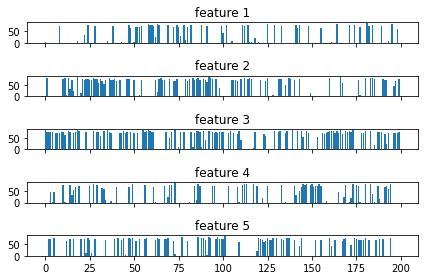

In [227]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
ax1.bar(range(200), selected_feature_counters[0])
ax1.set_title("feature 1")

ax2.bar(range(200), selected_feature_counters[1])
ax2.set_title("feature 2")

ax3.bar(range(200), selected_feature_counters[2])
ax3.set_title("feature 3")

ax4.bar(range(200), selected_feature_counters[3])
ax4.set_title("feature 4")

ax5.bar(range(200), selected_feature_counters[4])    
ax5.set_title("feature 5")

fig.tight_layout()

## Selection stability trhough selection frequency relative to bootstrap samples

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


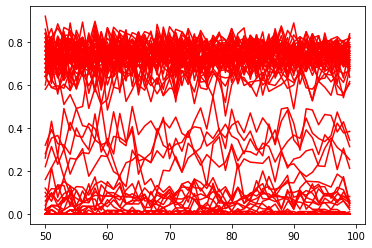

In [245]:
bs_min = 50
bs_max = 100
sample_size = 150
zero_tol = 0.0001

bs_list = []
for n_bootstrap_samples in range(bs_min, bs_max):
    print( n_bootstrap_samples )
    # Creating bootstrap sample and records how often a given feature is 
    # selected in the LogisticRegression for c_max.
    selected_feature_counters = np.asarray([
        np.zeros(k),
        np.zeros(k),
        np.zeros(k),
        np.zeros(k),
        np.zeros(k),
    ])
    for ix in range(n_bootstrap_samples):
        idx_list = np.random.choice(X_fstat.shape[1], sample_size, replace=False)
        X_bootstrap = X_fstat[:,idx_list]
        beta = LogisticRegression(C=c_max,
                                 multi_class='ovr', 
                                 solver='liblinear',
                                 intercept_scaling=10000).fit(X_bootstrap, y).coef_

        # Assumes that the beta arrays for the differen
        # classes comes in the same order, and calculates
        # the frequency with which every frequency is present
        jx = 0
        for class_beta in beta:
            non_zero_idx = np.where( class_beta > zero_tol )
            non_zero_feature_idx = idx_list[non_zero_idx]
            for idx in non_zero_feature_idx:
                selected_feature_counters[jx][idx] += 1
            jx += 1
    bs_list.append(selected_feature_counters)

for ix in range(k):  
    temp = np.asarray(bs_list)[:,0,ix]
    rng = np.asarray(range(bs_min, bs_max))
    plt.plot(rng, np.divide(temp, rng), color='red')